In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'E:/redd/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

In [3]:
def read_merge_data(house):
    path = 'E:/redd/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    #print(labels[house][1])
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))//2
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    print(df.values[0])
    f= open('E:/redd/low_freq_rect/house_{}/'.format(house)+'channel_{}'.format(house)+'.dat','a+') 
    f.write(df.to_string())
    f.close()
    return df
df = {}
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_rows',-1)
for i in range(1,7):
    df[i] = read_merge_data(i)

In [4]:
for i in range(1,7):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


House 3 data has shape:  (376150, 22)


,mains_1,mains_2,outlets_unknown_3,outlets_unknown_4,lighting_5,electronics_6,refrigerator_7,disposal_8,dishwaser_9,furance_10,...,washer_dryer_13,washer_dryer_14,lighting_15,microwave_16,lighting_17,smoke_alarms_18,lighting_19,bathroom_gfi_20,kitchen_outlets_21,kitchen_outlets_22
2011-05-31 00:19:30,15.45,2.23,0.0,1.0,1.0,1139.0,8.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:33,15.42,2.23,0.0,1.0,1.0,1138.0,8.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:36,15.44,2.23,0.0,1.0,1.0,1134.0,7.0,6.0,3.0,7.0,...,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5


House 4 data has shape:  (428076, 20)


,mains_1,mains_2,lighting_3,furance_4,kitchen_outlets_5,outlets_unknown_6,washer_dryer_7,stove_8,air_conditioning_9,air_conditioning_10,miscellaeneous_11,smoke_alarms_12,lighting_13,kitchen_outlets_14,dishwaser_15,bathroom_gfi_16,bathroom_gfi_17,lighting_18,lighting_19,air_conditioning_20
2011-06-04 00:45:31,403.36,94.65,173.0,27.0,38.0,3.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:35,401.11,94.63,174.0,27.0,34.0,4.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:38,400.24,94.43,175.0,27.0,38.0,4.0,1.0,5.0,0.0,0.0,2.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0


House 5 data has shape:  (77451, 26)


,mains_1,mains_2,microwave_3,lighting_4,outlets_unknown_5,furance_6,outlets_unknown_7,washer_dryer_8,washer_dryer_9,subpanel_10,...,lighting_17,refrigerator_18,lighting_19,dishwaser_20,disposal_21,electronics_22,lighting_23,kitchen_outlets_24,kitchen_outlets_25,outdoor_outlets_26
2011-06-01 00:20:07,151.68,37.39,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,0.0,2.0,0.0,0.0,5.0,115.0,0.0,0.0,0.0
2011-06-01 00:20:10,150.42,37.21,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,1.0,2.0,0.0,0.0,5.0,100.0,0.0,0.0,0.0
2011-06-01 00:20:14,149.29,37.10,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,...,0.0,0.0,2.0,0.0,0.0,5.0,97.5,0.0,0.0,0.0


House 6 data has shape:  (192192, 17)


,mains_1,mains_2,kitchen_outlets_3,washer_dryer_4,stove_5,electronics_6,bathroom_gfi_7,refrigerator_8,dishwaser_9,outlets_unknown_10,outlets_unknown_11,electric_heat_12,kitchen_outlets_13,lighting_14,air_conditioning_15,air_conditioning_16,air_conditioning_17
2011-06-14 01:12:25,19.82,401.65,4.0,3.0,1.0,0.0,4.0,140.0,0.0,87.0,0.0,7.0,1.0,114.0,4.0,0.0,0.0
2011-06-14 01:12:33,19.59,400.11,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,1.0,113.0,4.0,0.0,0.0
2011-06-14 01:12:36,19.59,399.47,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,0.0,113.0,4.0,0.0,0.0


In [5]:
dates = {}
for i in range(1,7):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

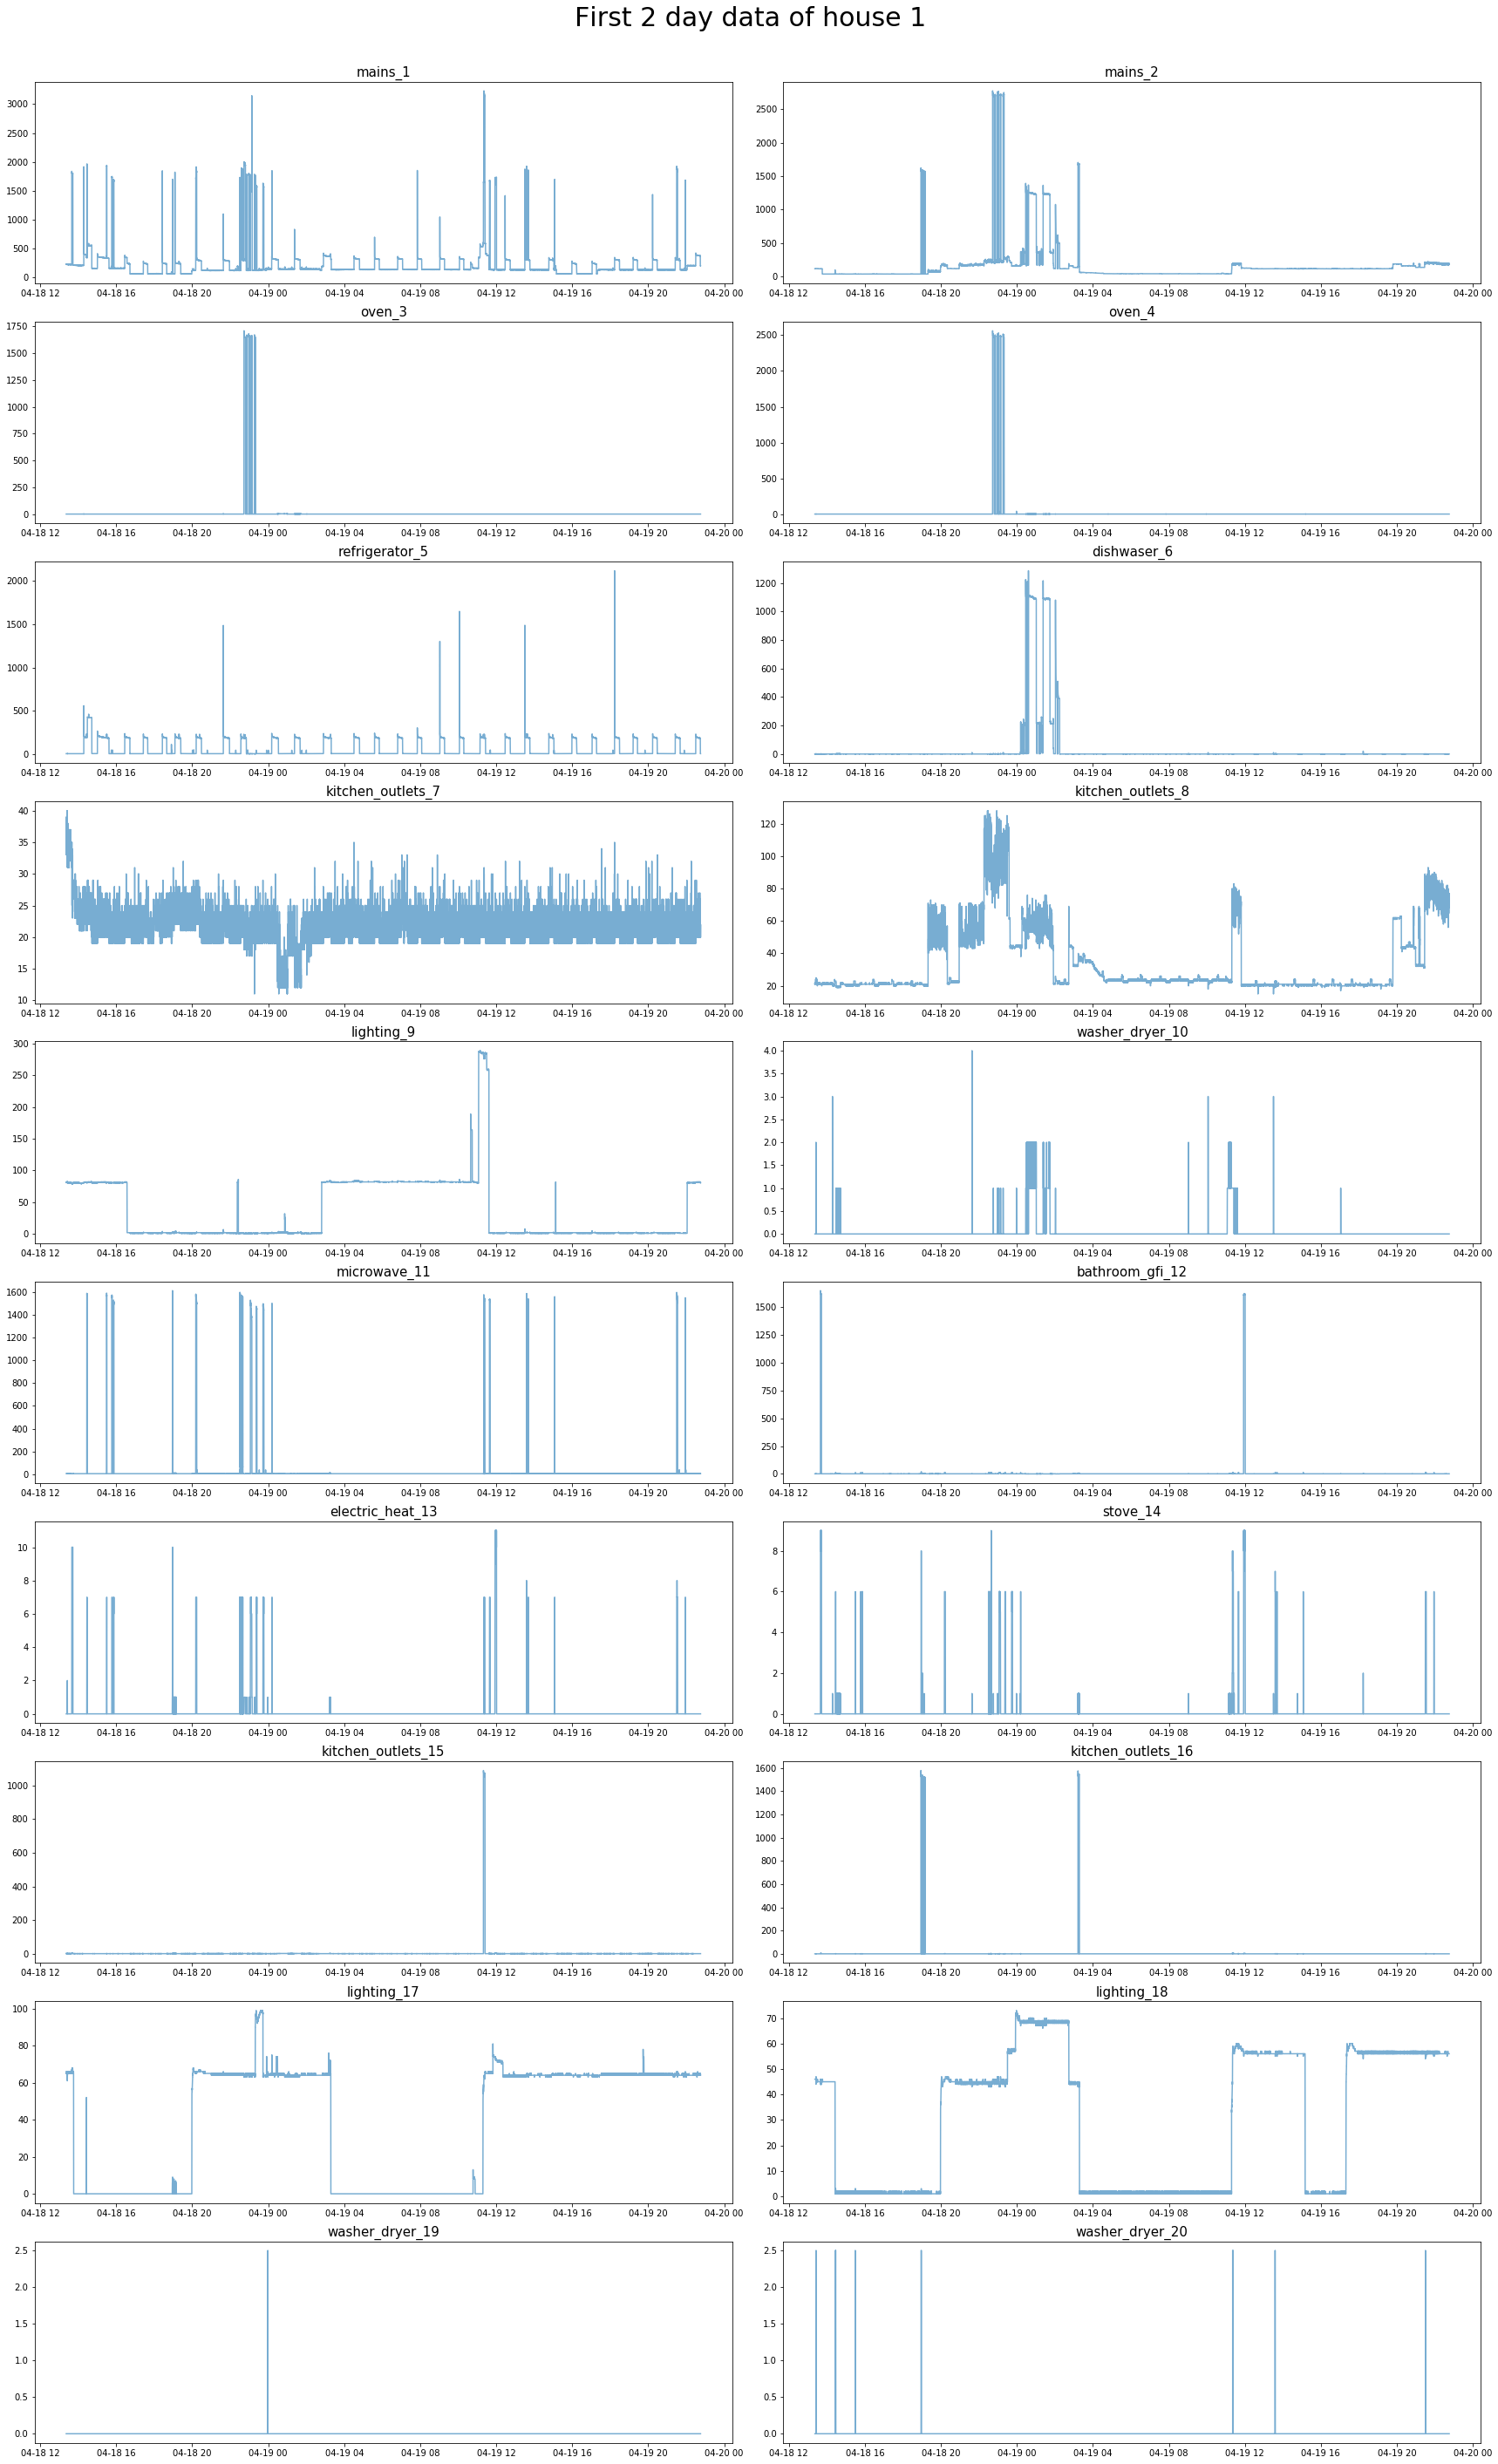

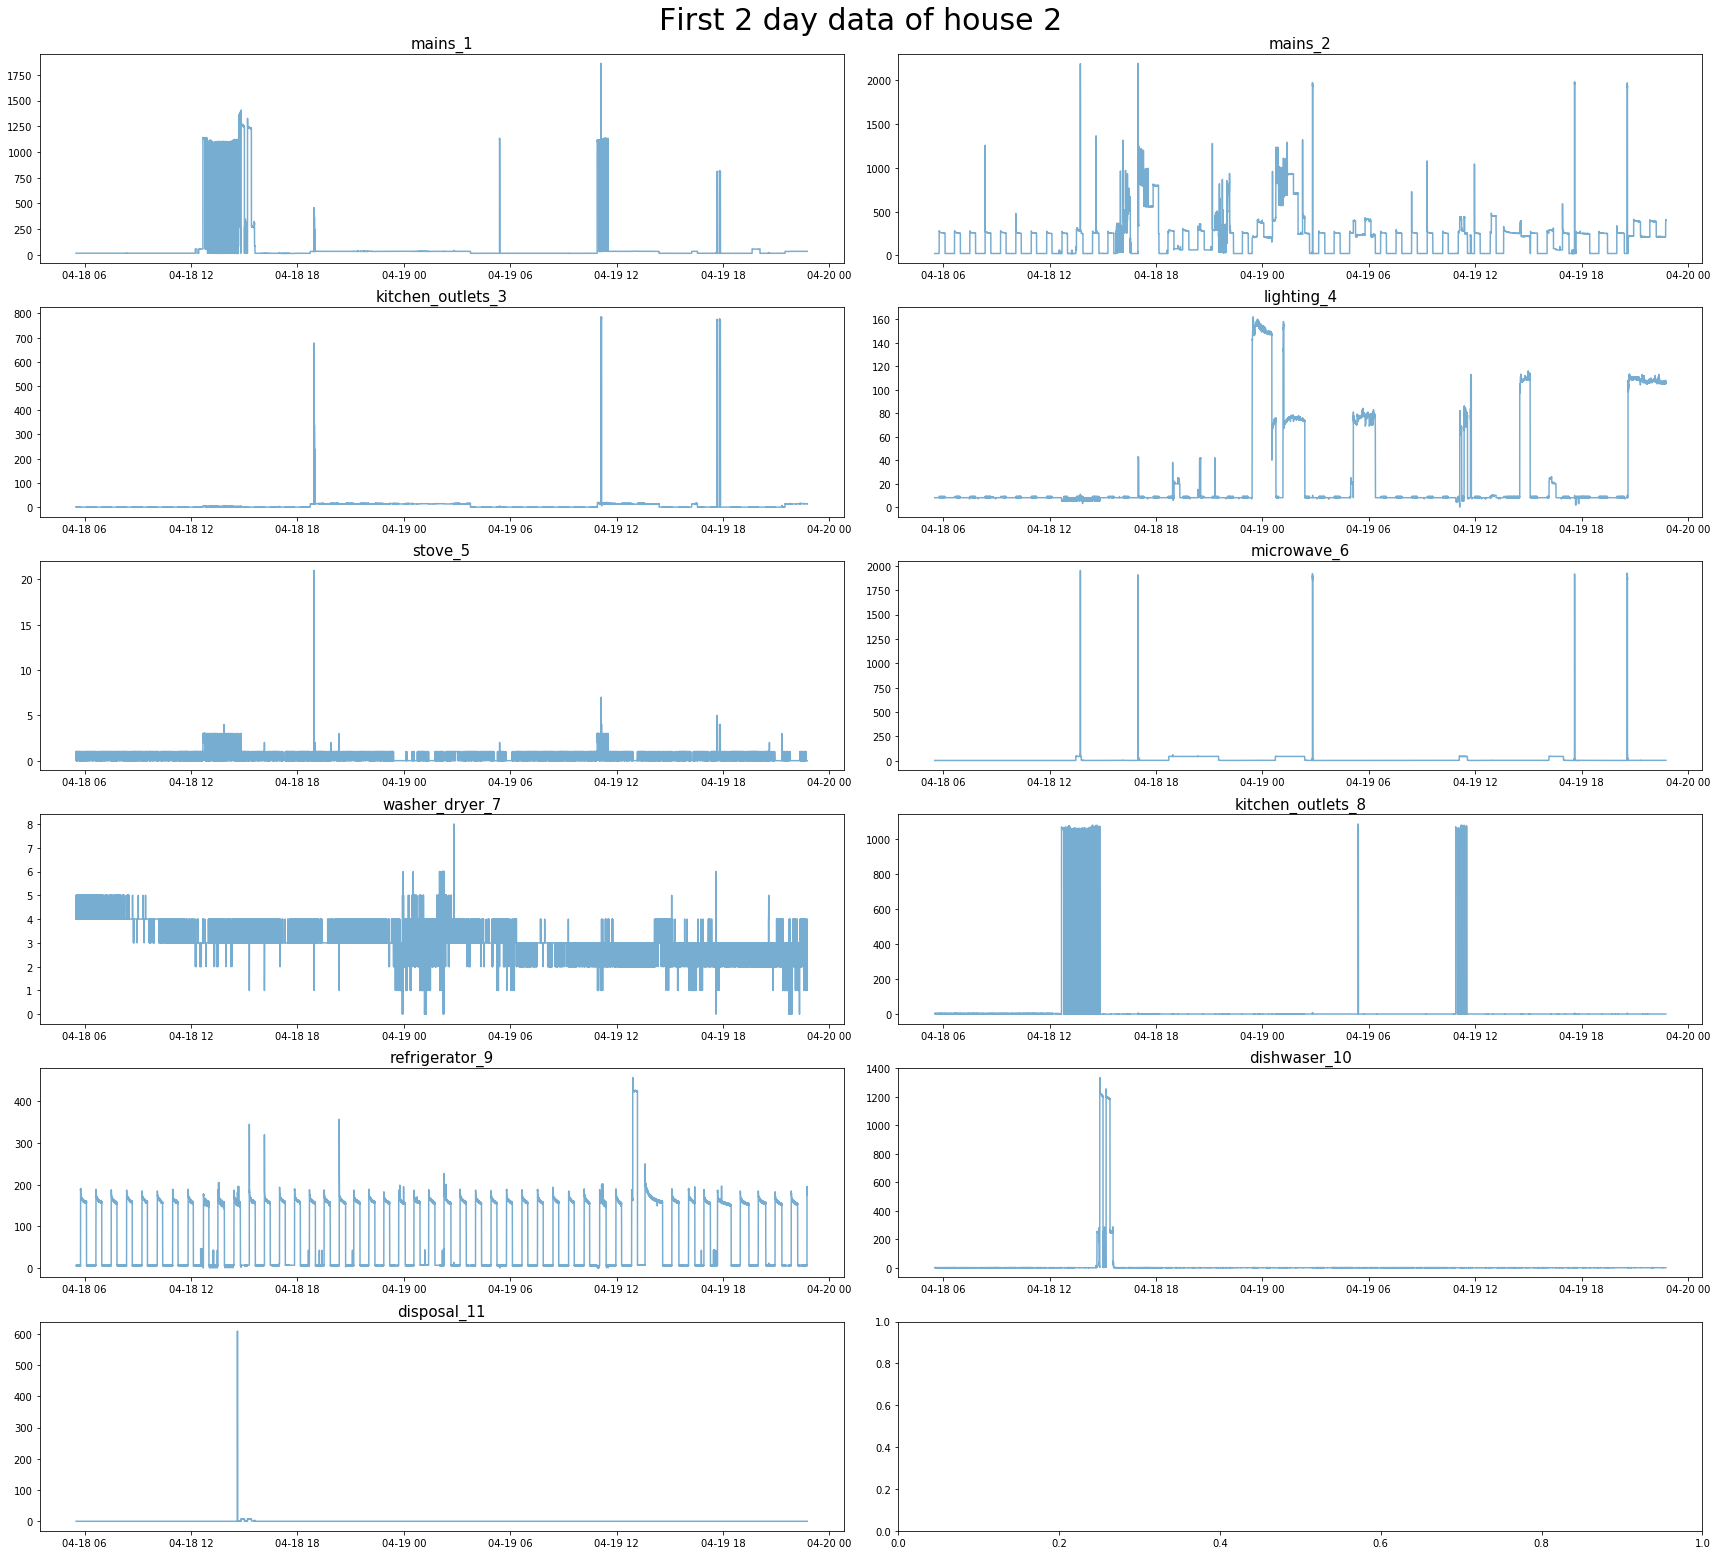

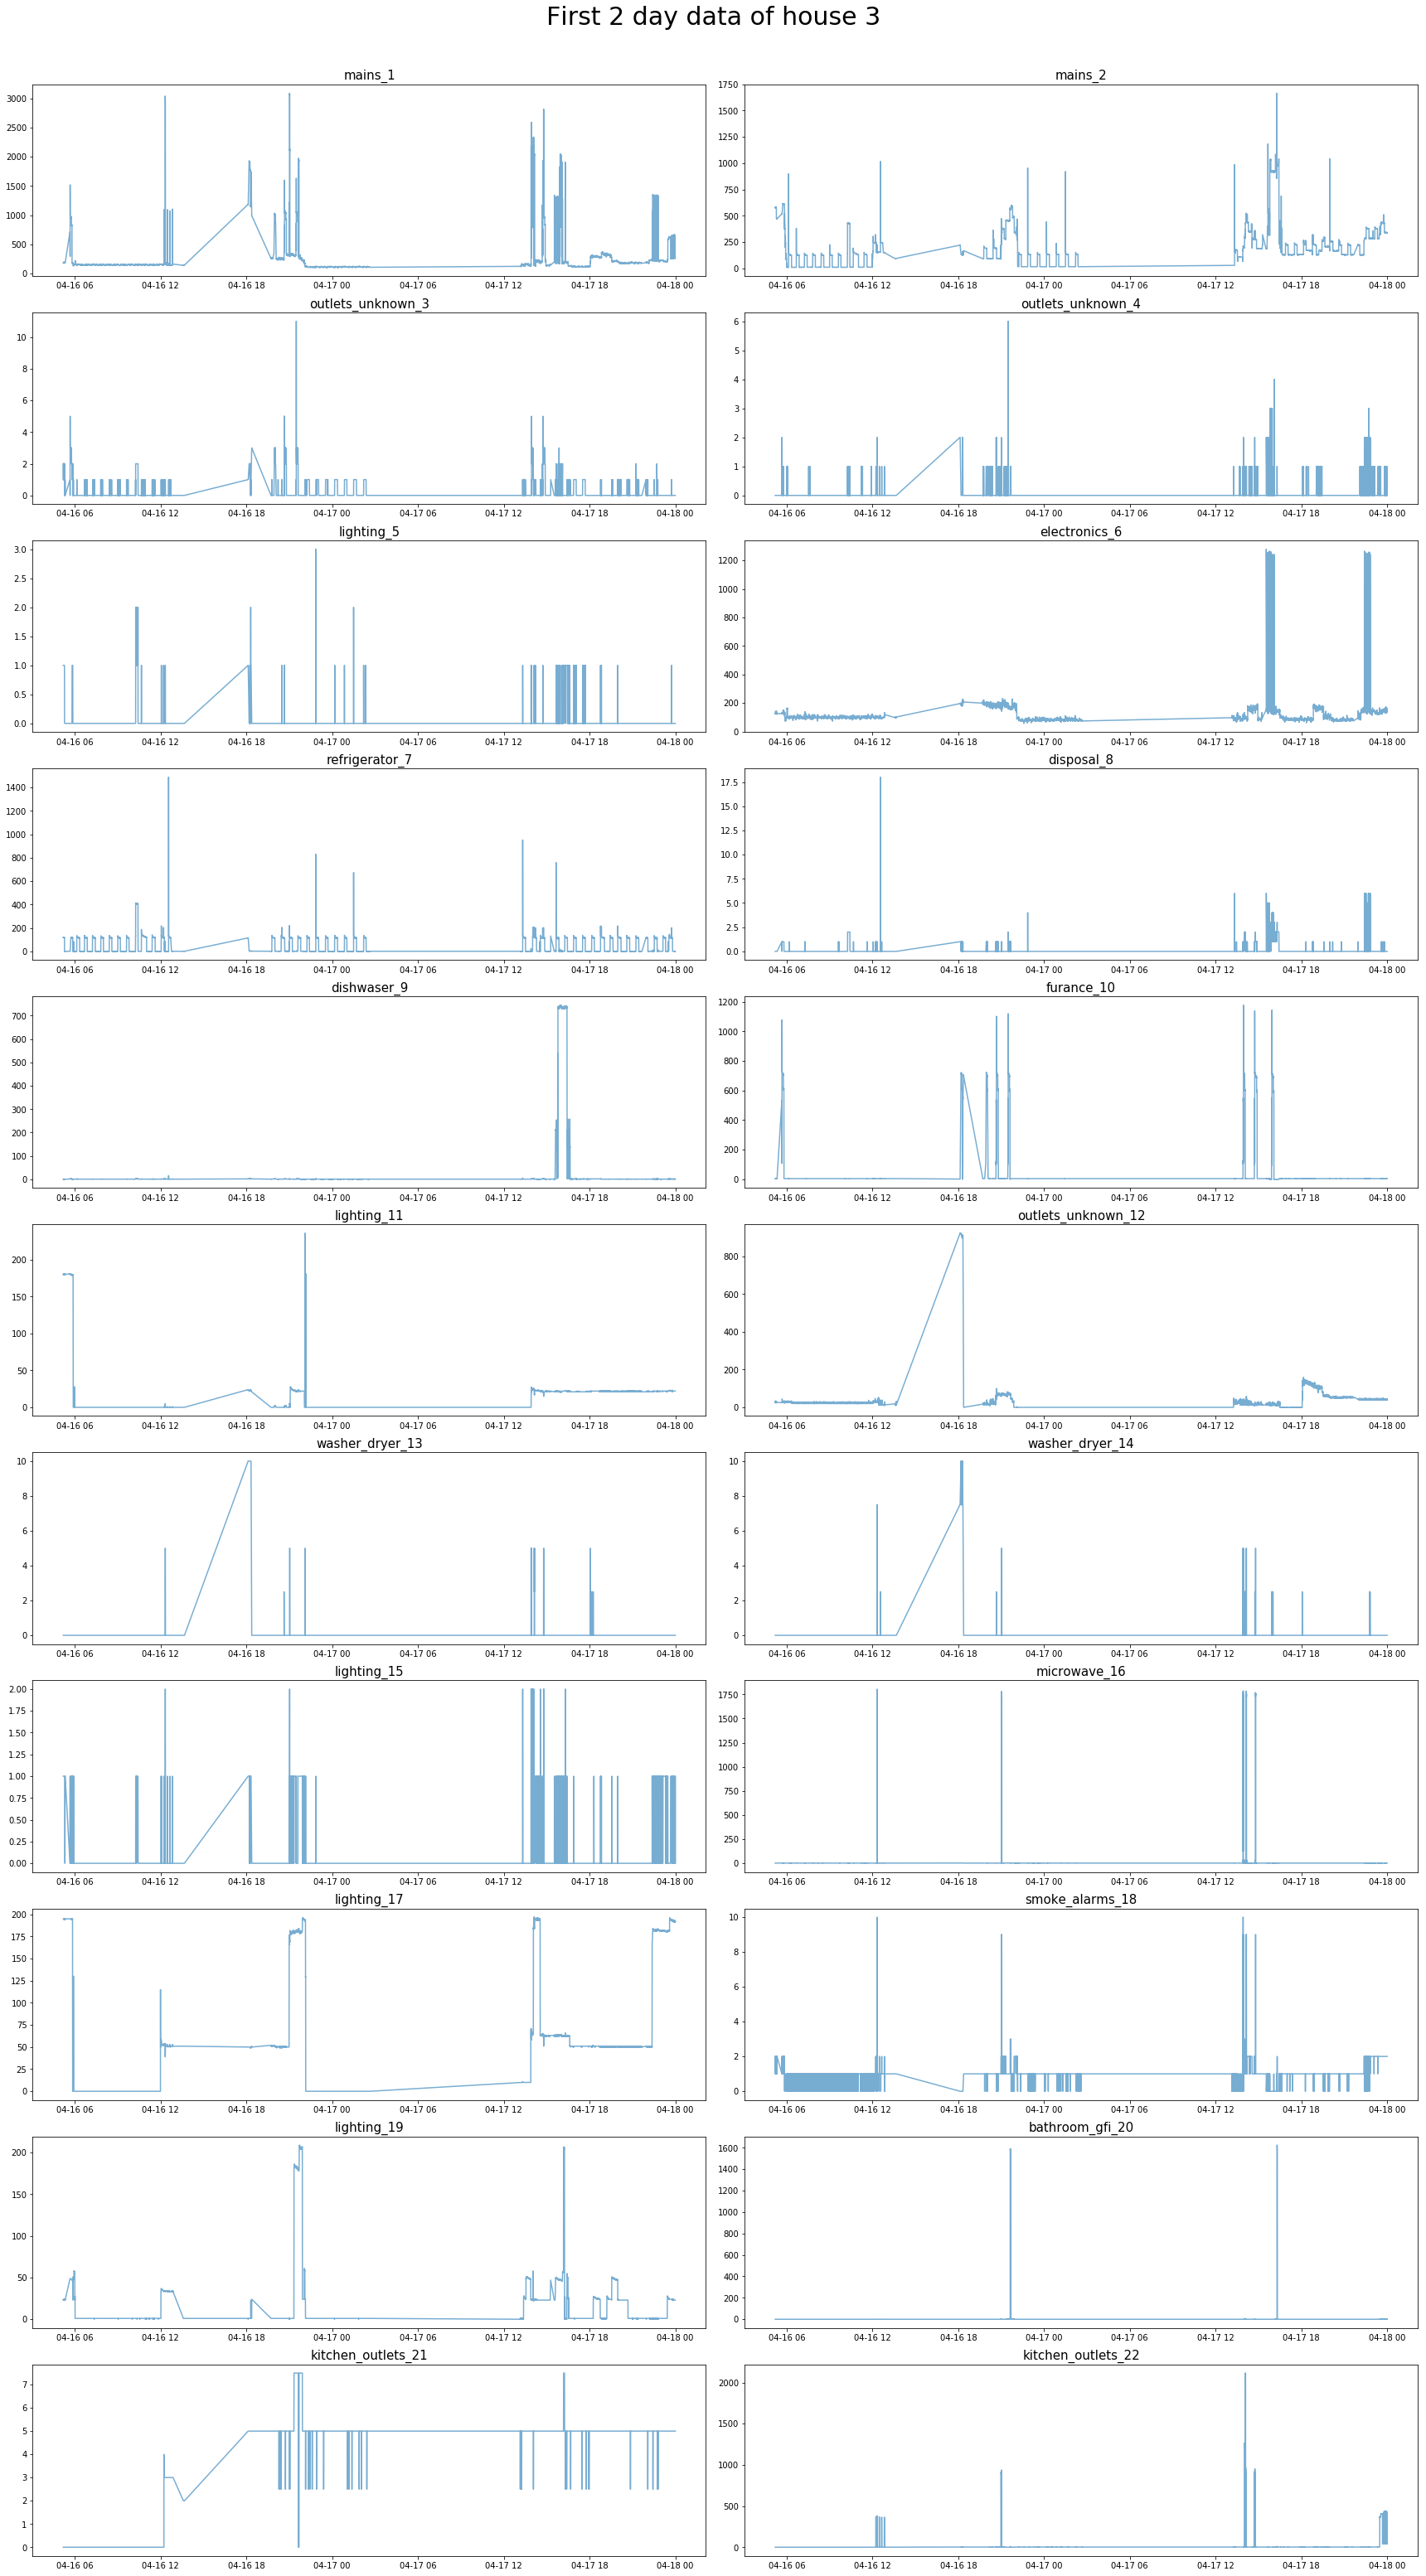

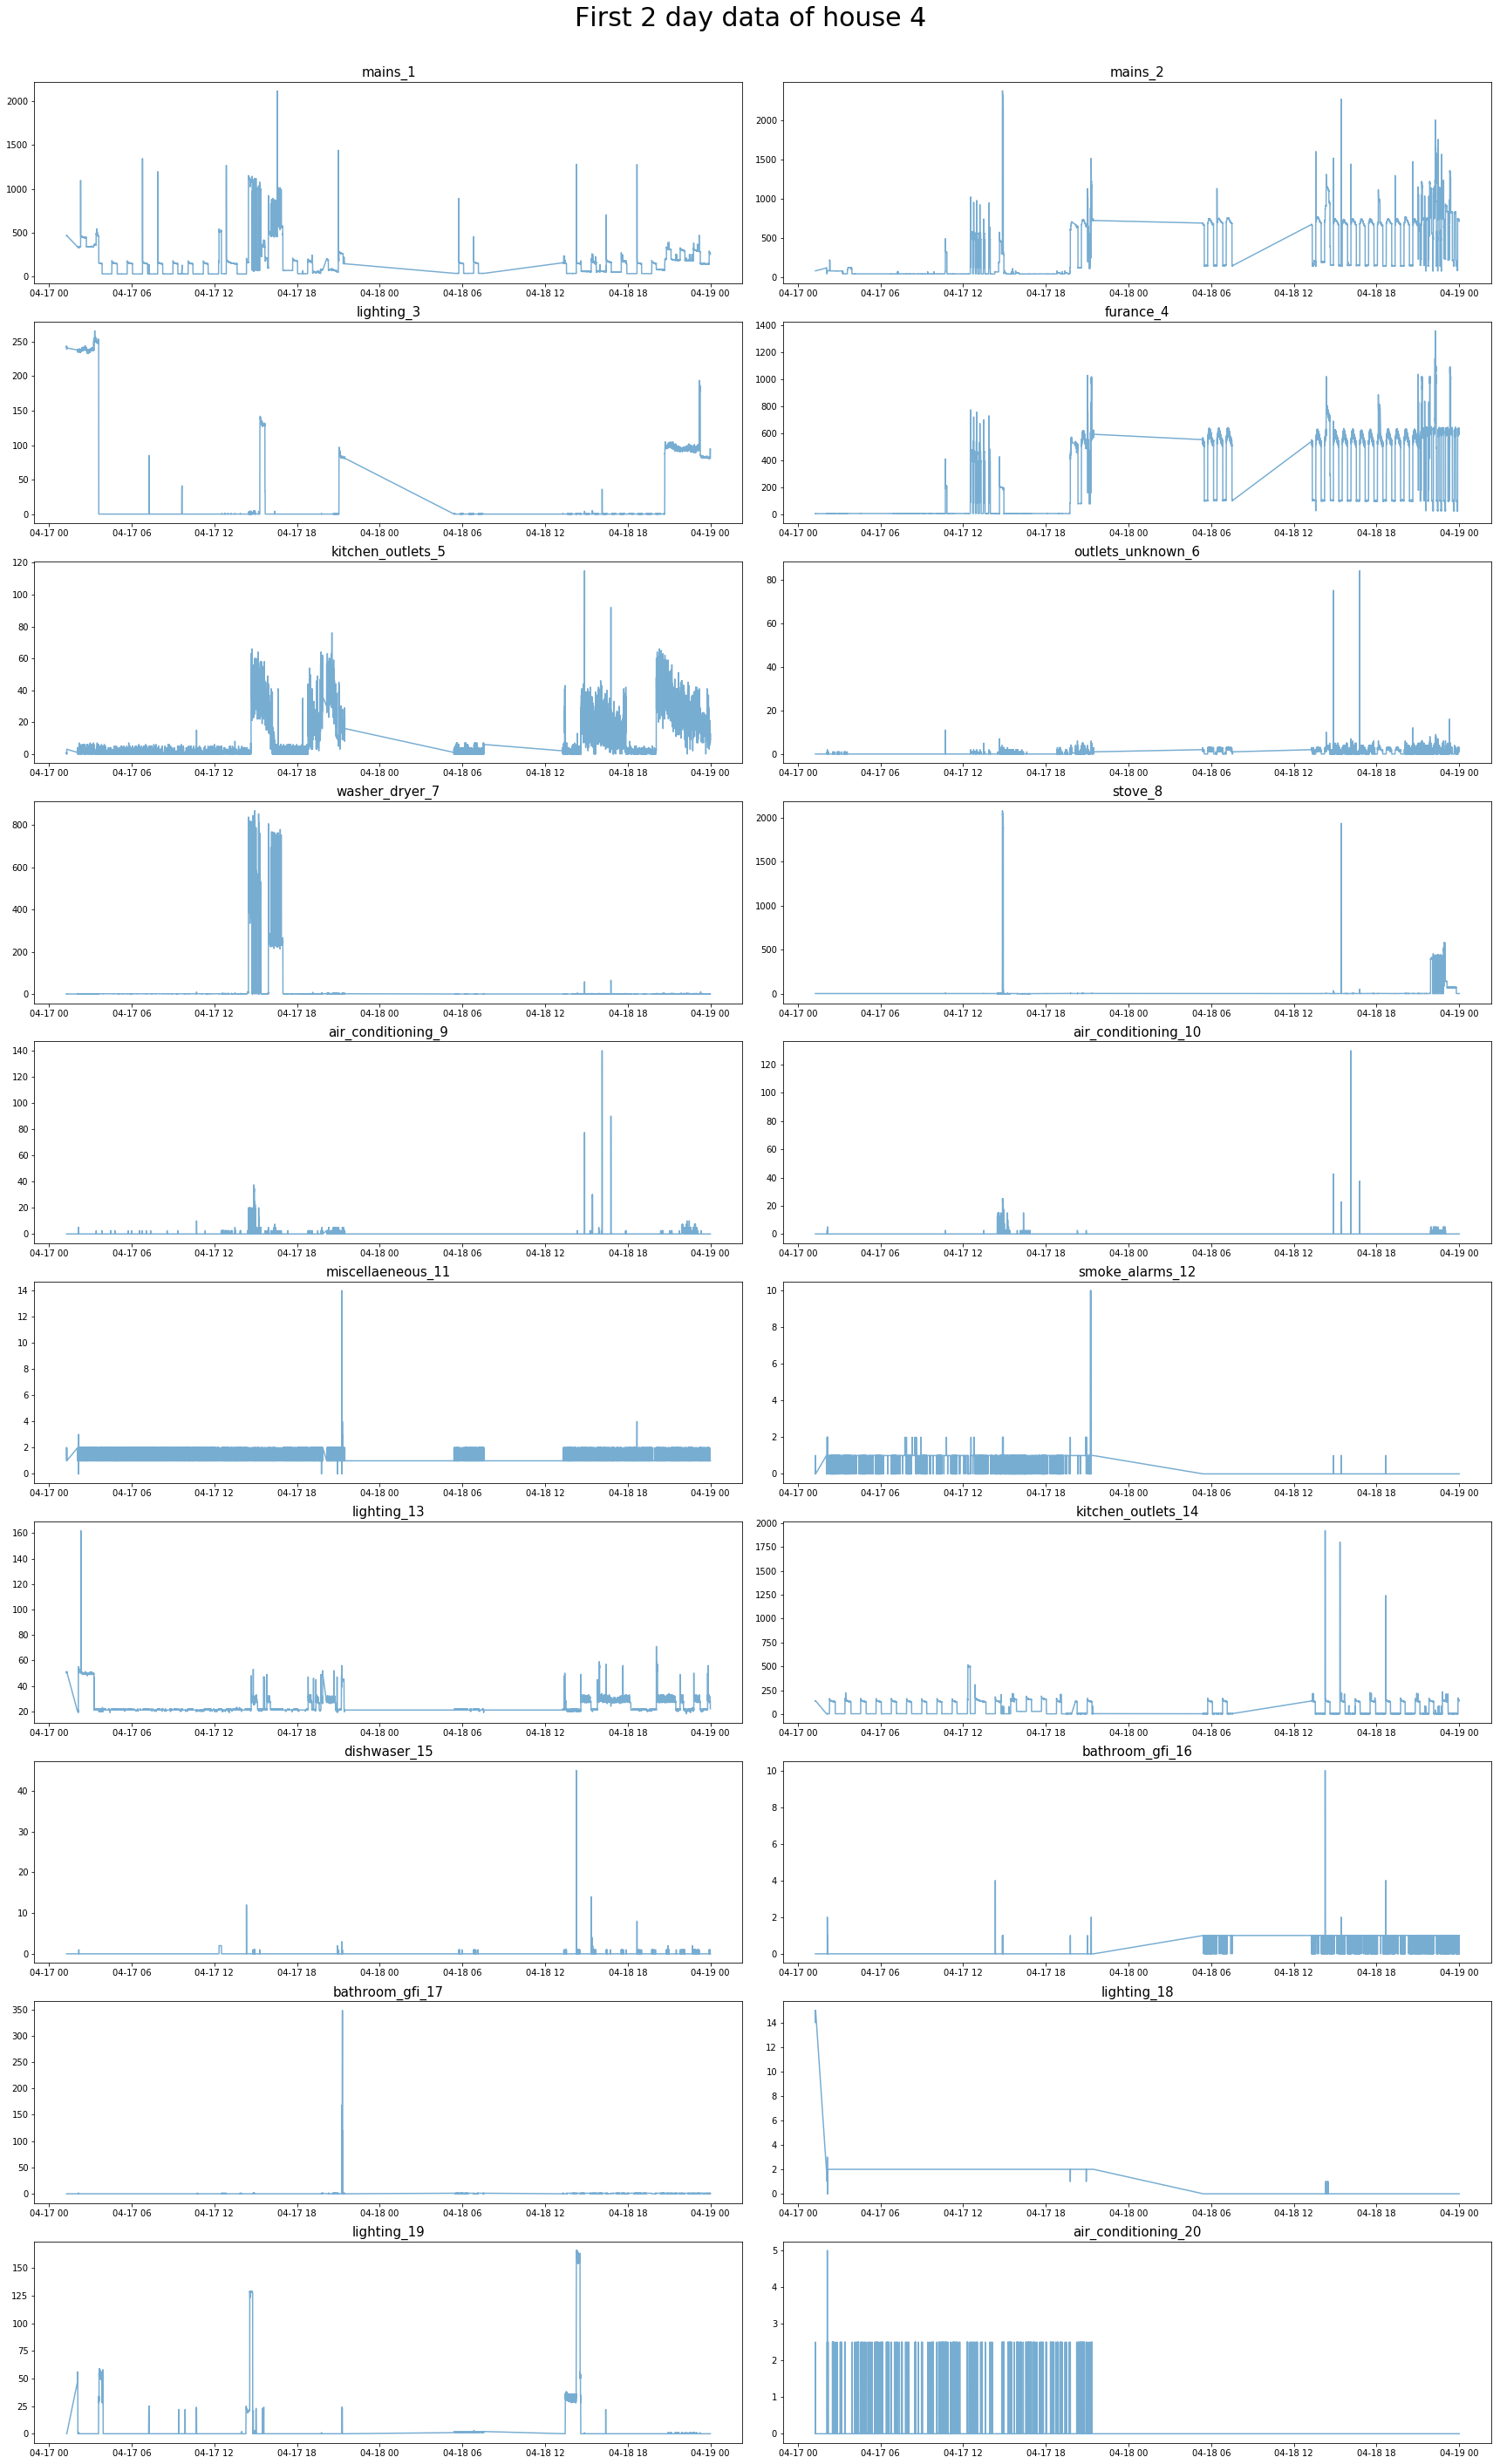

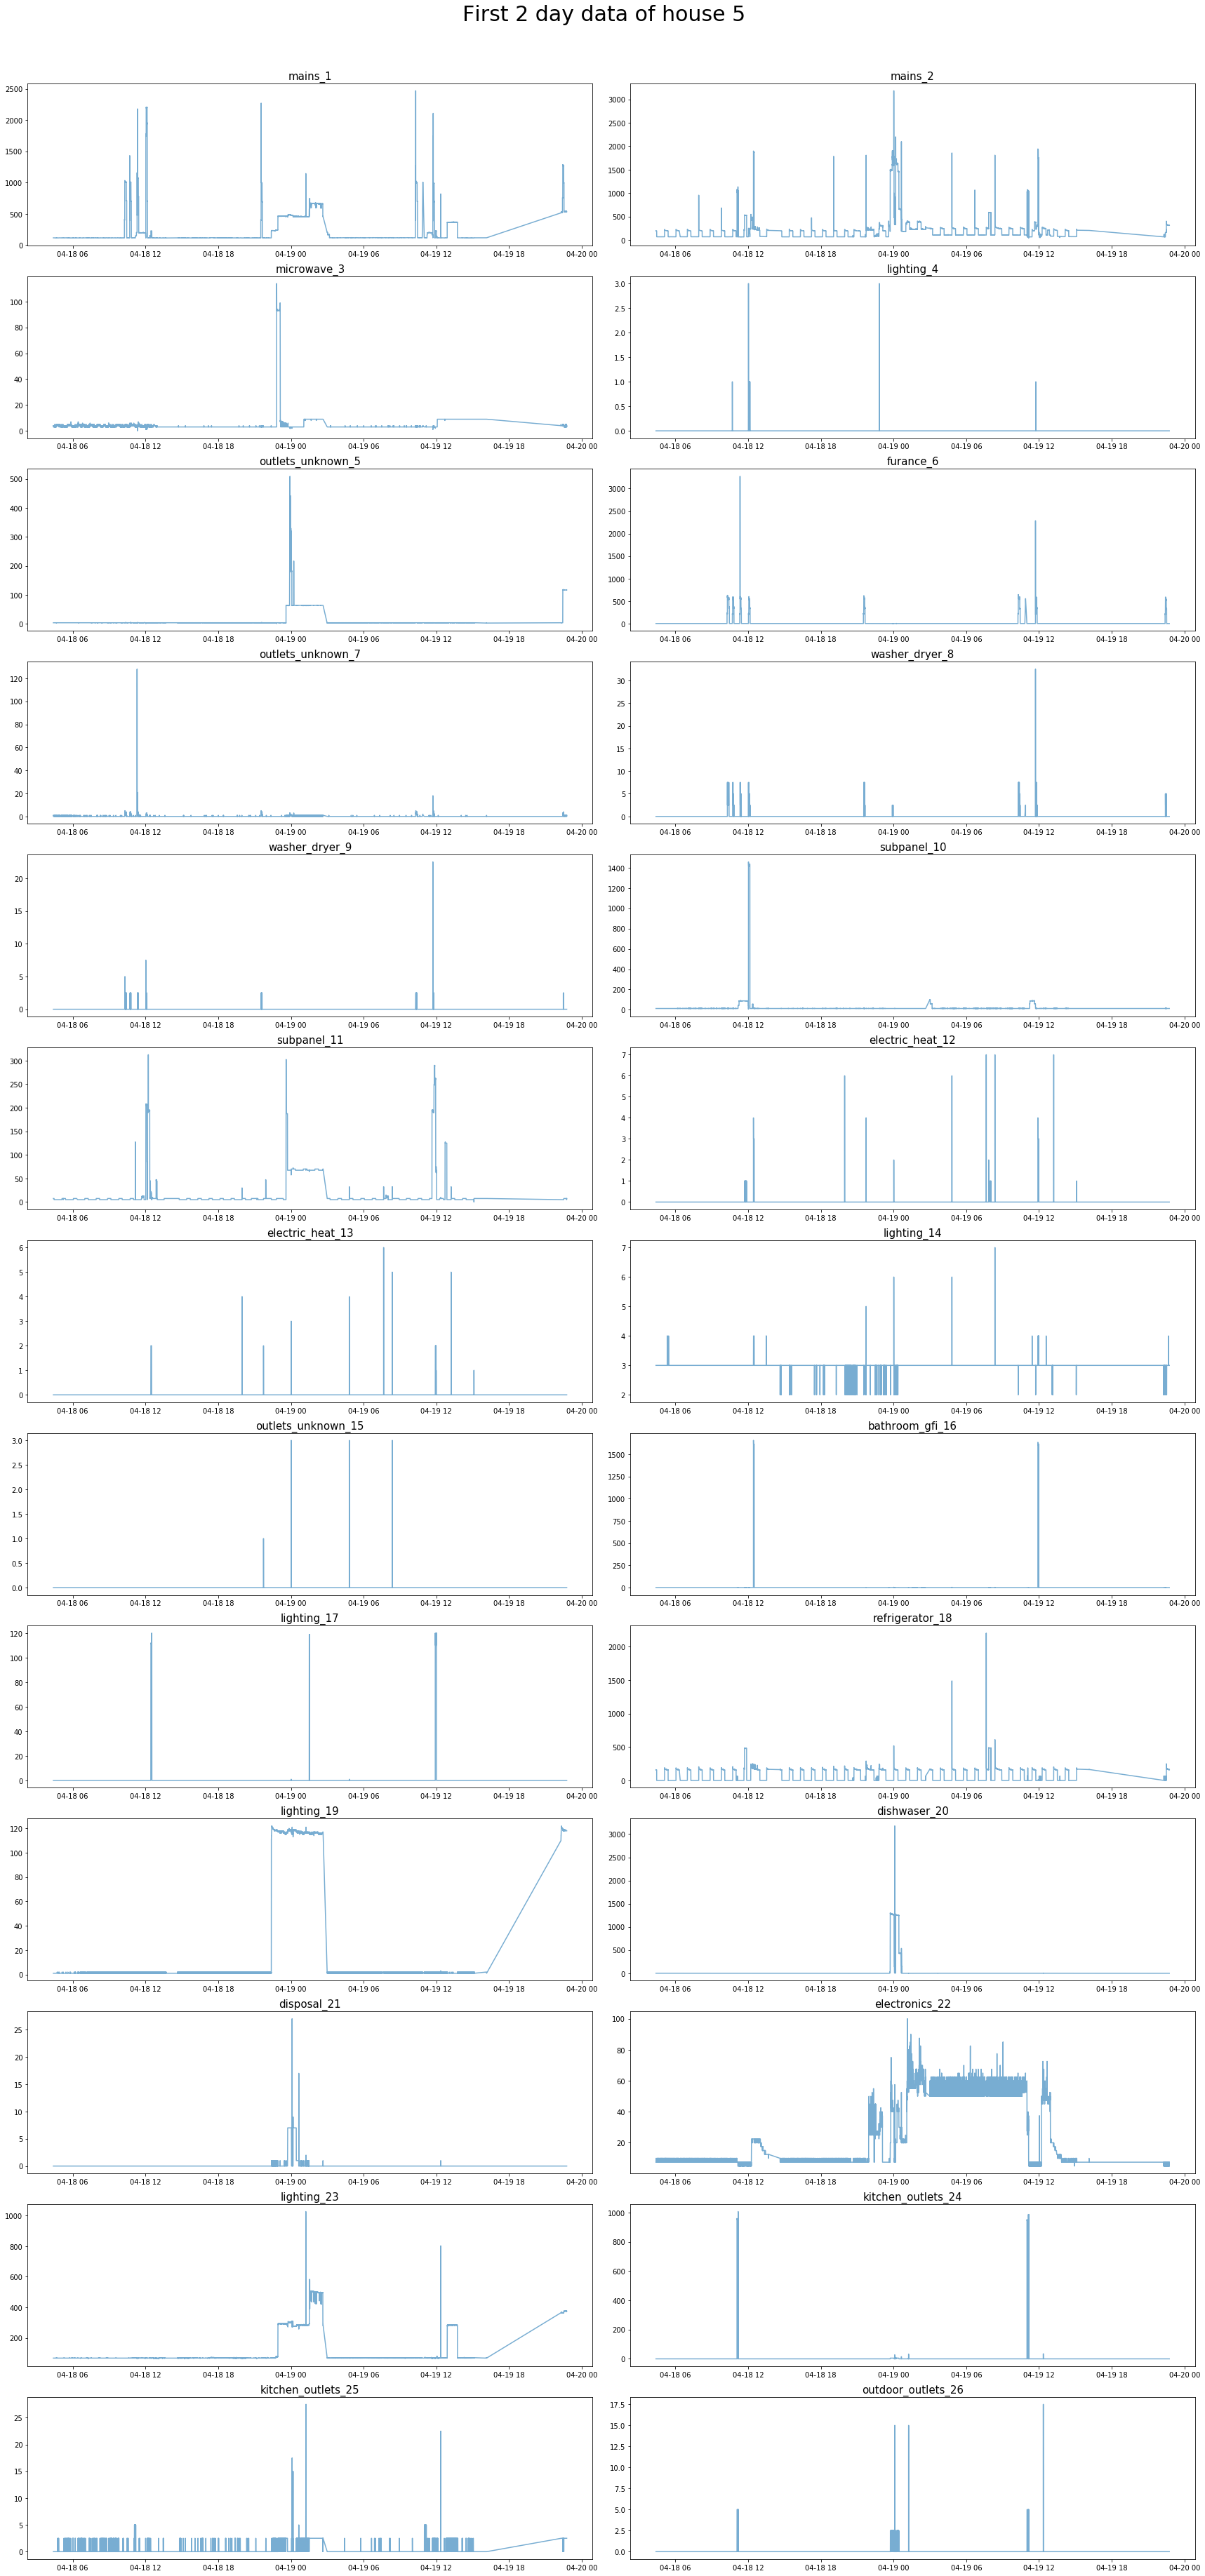

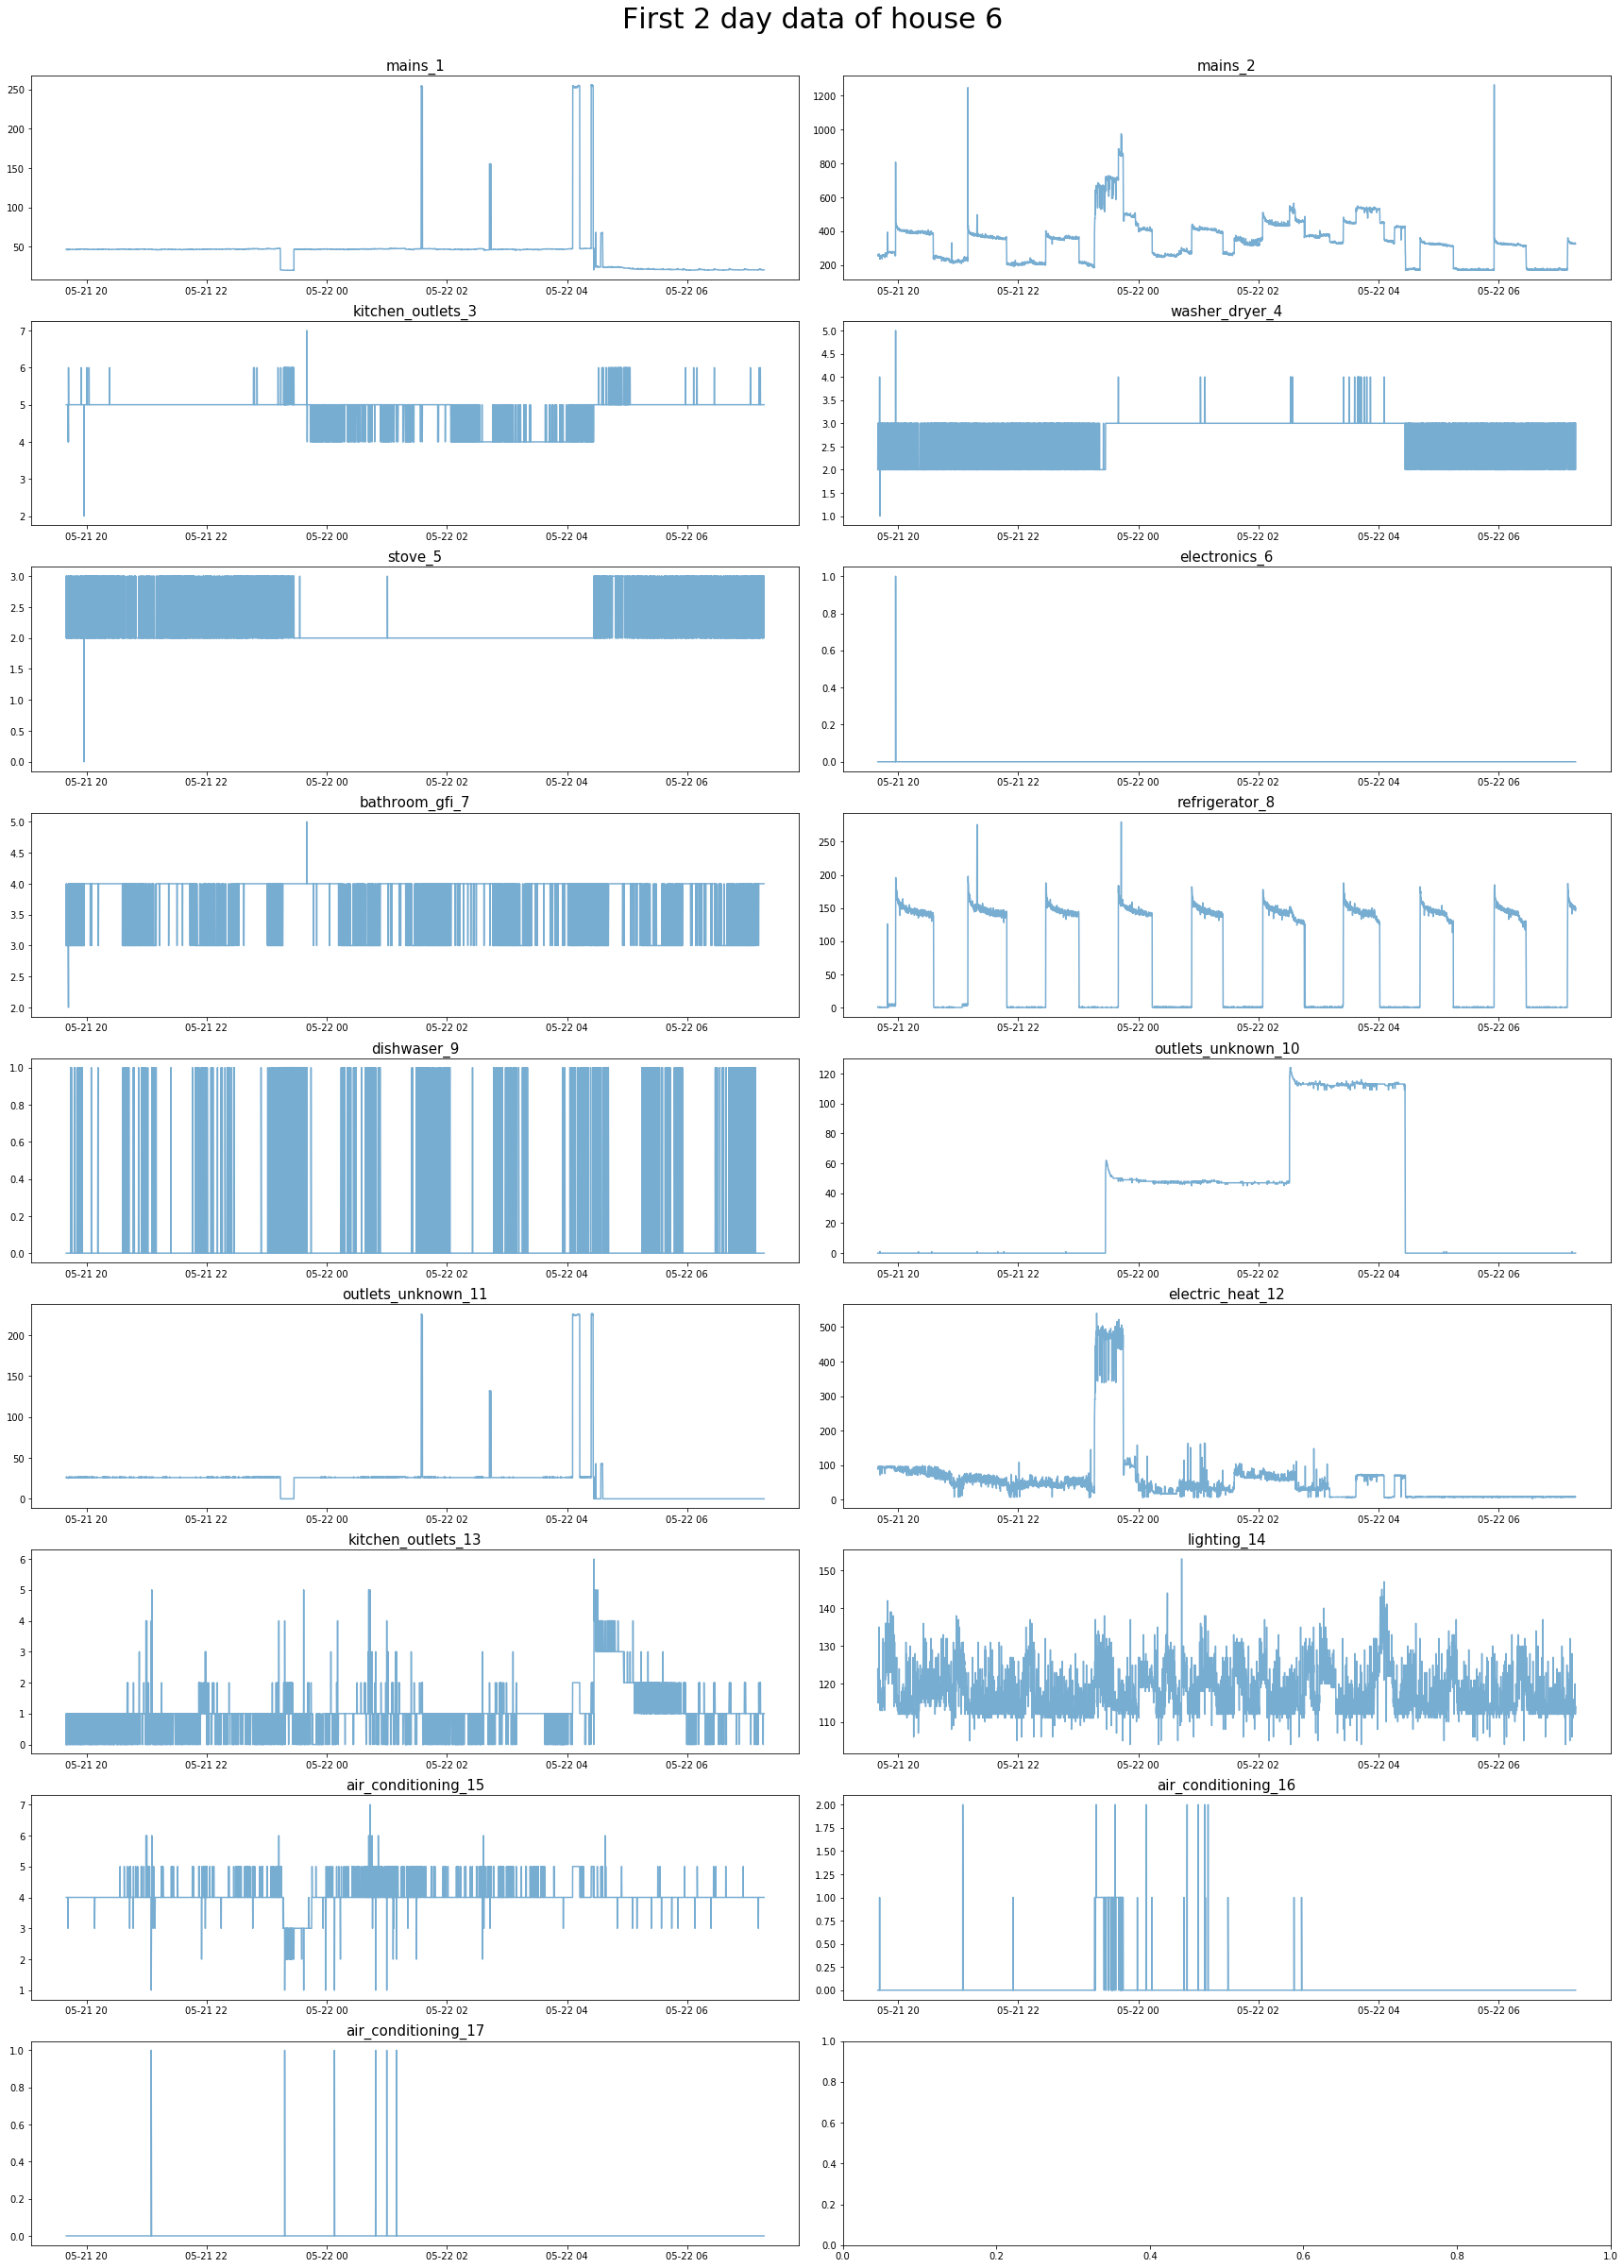

In [6]:
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,7):
    plot_df(df[i].ix[:dates[i][1]], 'First 2 day data of house {}'.format(i))


Text(0.5, 1.0, 'House 2')

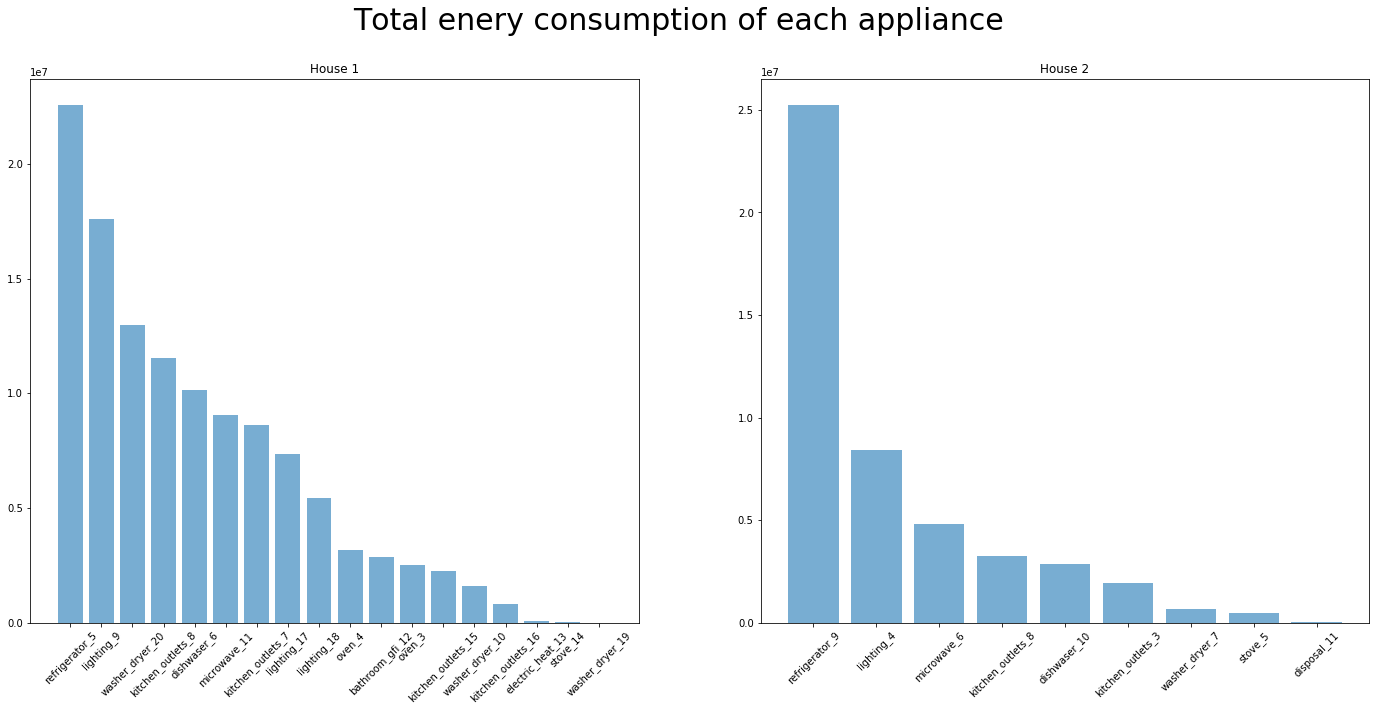

In [7]:
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

In [9]:
xg_reg = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [8]:
#print(df[1].keys())
print(df[1].ix[:dates[1][10]])

                     mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   
2011-04-18 13:22:30   222.90   118.76     0.0     0.0             6.0   
2011-04-18 13:22:33   222.96   118.88     0.0     0.0             6.0   
2011-04-18 13:22:37   222.54   118.36     0.0     0.0             6.0   
2011-04-18 13:22:40   226.03   119.17     0.0     0.0             6.0   
2011-04-18 13:22:44   222.96   119.03     0.0     0.0             6.0   
2011-04-18 13:22:47   223.52   118.82     0.0     0.0             6.0   
2011-04-18 13:22:51   227.29   119.17     0.0     0.0             6.0   
2011-04-18 13:22:54   221.72   118.61     0.0     0

In [31]:
#print(labels)
avg=0
c=0
for i in range(1,len(labels)+1):
    for j in range(5,len(labels[i])+1):
        print(labels[i][j])
        X_train, X_test, y_train, y_test = train_test_split(df[i][['mains_1','mains_2']], df[i][labels[i][j]], test_size=0.2, random_state=123)
        try:
            knn = KNeighborsClassifier(n_neighbors=30)
            knn.fit(X_train,y_train)
            avg+=knn.score(X_test,y_test)*100
            c+=1
            #print(" Accuracy on Test Set : {:.2f}%".format(knn.score(X_test,y_test)*100))
        except:
            continue
print(" Accuracy on Test Set : {:.2f}%".format(avg/c))

refrigerator_5
dishwaser_6
kitchen_outlets_7
kitchen_outlets_8
lighting_9
washer_dryer_10
microwave_11
bathroom_gfi_12
electric_heat_13
stove_14
kitchen_outlets_15
kitchen_outlets_16
lighting_17
lighting_18
washer_dryer_19
washer_dryer_20
stove_5
microwave_6
washer_dryer_7
kitchen_outlets_8
refrigerator_9
dishwaser_10
disposal_11
lighting_5
electronics_6
refrigerator_7
disposal_8
dishwaser_9
furance_10
lighting_11
outlets_unknown_12
washer_dryer_13
washer_dryer_14
lighting_15
microwave_16
lighting_17
smoke_alarms_18
lighting_19
bathroom_gfi_20
kitchen_outlets_21
kitchen_outlets_22
kitchen_outlets_5
outlets_unknown_6
washer_dryer_7
stove_8
air_conditioning_9
air_conditioning_10
miscellaeneous_11
smoke_alarms_12
lighting_13
kitchen_outlets_14
dishwaser_15
bathroom_gfi_16
bathroom_gfi_17
lighting_18
lighting_19
air_conditioning_20
outlets_unknown_5
furance_6
outlets_unknown_7
washer_dryer_8
washer_dryer_9
subpanel_10
subpanel_11
electric_heat_12
electric_heat_13
lighting_14
outlets_unknow

In [11]:
print(X_train)

                     mains_1  mains_2
2011-04-20 05:02:58   132.99    41.93
2011-05-07 03:38:48   129.23    41.33
2011-05-13 07:04:23    92.77    38.61
2011-05-24 00:23:16   173.52   190.32
2011-04-23 16:49:25   125.78  1281.11
2011-05-02 19:51:19    54.03    38.86
2011-04-26 12:12:04   116.53   126.31
2011-05-13 01:08:28    57.91    38.00
2011-05-12 16:34:21    55.48    38.79
2011-04-18 21:17:57   114.69   167.67
2011-04-25 04:42:13   130.89    40.92
2011-04-22 21:35:14   233.73    55.28
2011-05-03 12:44:00   128.12  1123.69
2011-04-23 01:28:33   146.80   122.50
2011-04-24 11:53:33   319.17    41.19
2011-05-03 11:27:10  1804.68   319.86
2011-05-01 04:40:42   318.43    41.22
2011-04-19 20:53:47   126.64   161.65
2011-04-30 17:39:23   125.60   727.82
2011-04-25 03:16:48   129.28    41.05
2011-04-27 08:20:34   131.03    38.51
2011-04-25 17:41:45    56.42    38.50
2011-05-11 19:05:40    67.52    38.85
2011-04-23 20:04:32    55.29    44.34
2011-04-24 01:39:08   233.58    41.73
2011-04-22 0

In [15]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[20:08:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 24.712535


In [21]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train,y_train)
print(" Accuracy on Test Set : {:.2f}%".format(knn.score(X_test,y_test)*100))

 Accuracy on Test Set : 92.86%
